# Mathematical Foundations of Computer Graphics and Vision 2023
## Exercise 1 - Robust Estimation and Optimization

In this exercise you will apply what you learned about robust optimization, especially RANSAC and Iteratively Reweighted Least Squares (IRLS). You will implement RANSAC for circle fitting in the presence of outliers, IRLS for line fitting with $L_1$ norm, and LP for line fitting with $L_1$ and $L_\infty$ norms.

We have implemented a skeleton notebook and you have to fill out blocks marked with `TODO`. Please refrain from modifying the notebook outside of the `START` and `END` blocks for the coding problems apart from new cells you create.

<b style="color:red">Use numpy vectorization</b> instead of python loops where explicitly noted. We may deduct points if your code runs unreasonably slow due (see the "test case" cell).

In [1]:
%matplotlib inline
import math
from typing import Tuple, List, Optional
import itertools
from collections import namedtuple

import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


np.random.seed(123)

## Part 1: RANSAC for circle fitting

In [2]:
# Default parameters
N = 100  # number of total points
D = 10  # half-domain size
tau = 0.1  # inlier distance threshold

### 1.1. Data Generation and Model Fitting

In [3]:
class Polynomial:
    def __init__(self, coefficients):
        self._coefficients = coefficients

    def __repr__(self):
        return f"Polynomial({self._coefficients.tolist()})"

    @property
    def degree(self):
        return len(self._coefficients) - 1

    def evaluate(self, x):
        """
        x - (N,1) array with the `x` coordinates

        Returns - (N,1) array with their `y` coordinates
        """

        y = np.ones_like(x)

        # TODO: evaluate the polynomial at points x
        # Use numpy vectorization!
        # START

        powers = np.arange(len(self._coefficients))
        y = np.power(x.reshape(-1, 1), powers) @ self._coefficients
        # END

        return y

    def is_inlier(self, points: np.ndarray, threshold: float = tau):
        """
        points - Nx2 array with the data points

        Returns - bool vector of size N, where i-th element indicates if i-th point of `points` is an inlier
        """
        is_inlier = np.ones((points.shape[0],), dtype=bool)

        # TODO : Fill vector `is_inlier`, for i-th element to indicate if i-th point of `points` is an inlier
        # Use `self.evaluate`
        # Use numpy vectorization!
        # START
        X, Y = points[:,0], points[:,1]
        is_inlier = np.abs(self.evaluate(X) - Y) <= threshold
        # END

        return is_inlier

    def generate_points(self, r: float, n_points: int = N) -> Tuple[np.ndarray, np.ndarray]:
        """
        r - outlier ratio
        n_points - number of points to generate

        Returns - tuple of inliers and outliers, each defined as an Nx2 array of the respective points
        """
        n_outliers = int(n_points * r)
        n_inliers = n_points - n_outliers

        inliers = np.random.uniform(-D, D, (n_inliers, 2))
        outliers = np.random.uniform(-D, D, (n_outliers, 2))

        # TODO : Implement Task 1.1. Make use of `self.evaluate` and `self.is_inlier` for that
        # START

        # replace accidental inliers with outliers
        inlier_mask = self.is_inlier(outliers, tau)
        while any(inlier_mask):
            outliers[inlier_mask] = np.random.uniform(-D, D, (np.sum(inlier_mask), 2))
            inlier_mask = self.is_inlier(outliers, tau)

        # evaluate inliers and reject one outside of the domain
        estimate_mask = np.ones(n_inliers, dtype=bool)
        while any(estimate_mask):
            noise = np.random.uniform(-tau, tau, np.sum(estimate_mask))
            inliers[estimate_mask, 0] = np.random.uniform(-D, D, np.sum(estimate_mask))
            inliers[estimate_mask, 1] = self.evaluate(inliers[estimate_mask, 0]) + noise
            estimate_mask = np.abs(inliers[:, 1]) > D

        # END

        return inliers, outliers

    @staticmethod
    def fit(points: np.ndarray) -> "Polynomial":
        """
        points - Nx2 array

        Returns - (N-1)-th degree polynomial going through all the `points`
        """
        if points.shape[1] != 2:
            raise ValueError("Bad point dimmensions")

        deg = points.shape[0] - 1

        coefficients = np.zeros(deg + 1)

        # TODO : Compute the (N-1)th degree polynomial coefficients that goes through
        #        all the `points` and fill `coefficients`
        # You do not need to handle singular cases - you can just return zeros
        # START
        x, y = points[:,0], points[:,1]
        powers = np.arange(len(coefficients))
        X = np.power(x.reshape(-1, 1), powers)
        Xt_X = X.T @ X

        is_singular = np.abs(np.linalg.det(Xt_X)) < 1e-10
        if is_singular:
            return Polynomial(coefficients)

        coefficients = np.linalg.inv(Xt_X) @ X.T @ y

        # END

        return Polynomial(coefficients)

#### Tests and Visualization

There is no need to modify these cells (but read the comments).

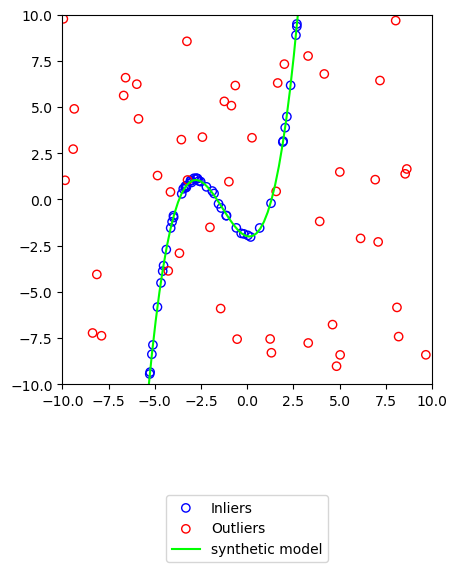

In [4]:
def plot_models(ax, inliers, outliers, synth_model: Polynomial, estimated_model: Optional[Polynomial] = None, title = None):
    ax.scatter(inliers[:, 0], inliers[:, 1], label="Inliers", c='none', edgecolors='blue')
    if outliers is not None:
        ax.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", c='none', edgecolors='red')

    x = np.linspace(-10, 10, 100)[:, None]
    if estimated_model is not None:
        y = estimated_model.evaluate(x)
        ax.plot(x, y, color='black', label="estimated model")

    if title is not None:
        ax.set_title(title)

    y = synth_model.evaluate(x)
    ax.plot(x, y, color='lime', label='synthetic model')

    ax.set_ylim(bottom=-D, top=D)
    ax.set_xlim(left=-D, right=D)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(0.5, -0.5), loc="lower center")

# Plotting the ground truth inliers/outliers
poly_a = Polynomial(np.array([-2, -0.25, 1, 0.25]))
inliers, outliers = poly_a.generate_points(0.5)
fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_a)
plt.show()
plt.close(fig)

In [5]:
%%time
# A simple non-complete test case for the data generation part
# It should not take more than a few seconds to run it.

test_points = np.array([[-5.01341822, -7.11485119],
                        [ 1.86544097,  2.59891622],
                        [-0.37093626, -1.7499924 ],
                        [-7.8621905 , -0.45595404]])

inliers, outliers = poly_a.generate_points(0.5, 1000000)
assert poly_a.is_inlier(inliers).all(), "Bad inliers"
assert (~poly_a.is_inlier(outliers)).all(), "Bad outliers"
assert np.abs(inliers).max() <= D, "Inliers outside of the domain"
assert np.abs(outliers).max() <= D, "Outliers outsie of the domain"

assert (poly_a.is_inlier(test_points) == np.array([*([True] * 3), False])).all(), "Failed test case"

CPU times: user 3.84 s, sys: 11.1 s, total: 14.9 s
Wall time: 1.33 s


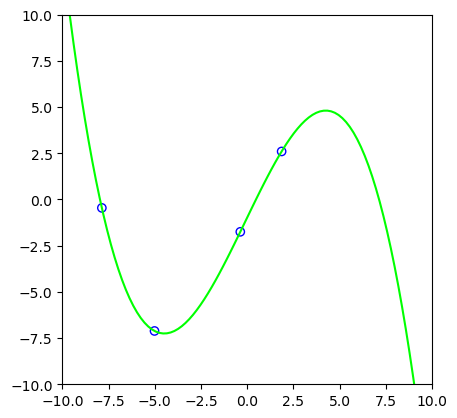

In [6]:
# Visualizing `fit` implementation. No need to edit this
def plot_fitted_poly(points, poly):
    fig, ax = plt.subplots()
    plot_models(ax, points, points[:0], poly)
    ax.get_legend().remove()
    plt.show()
    plt.close(fig)

poly = Polynomial.fit(test_points)

plot_fitted_poly(test_points, poly)

### 1.2. RANSAC

In [7]:
def get_ransac_iterations(r: float, sample_size: int, p: float) -> int:
    """
    r - outlier ratio
    sample_size - minimum data
    p - success rate

    Returns - number of RANSAC iterations to achieve `p` success rate
    """
    n = 1

    # TODO : Compute the minimum number of RANSAC iterations necessary to achieve `p` success rate
    # START
    n = math.ceil(np.log(1-p) / np.log(1-pow(1-r, sample_size)))

    # END

    return n

In [8]:
def run_ransac(points: np.ndarray, n_iter: int, sample_size: int) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    n_iter - number of ransac iterations
    sample_size - number of samples required to fit the model

    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the final Polynomial model
    """

    n_points = points.shape[0]
    inliers = points[:0]
    outliers = points
    poly = None

    # TODO : Implement 1.2 - RANSAC for model fitting
    # START
    for it in range(n_iter):
      sample_id = np.random.choice(np.arange(n_points), size=sample_size, replace=False)
      poly_test = Polynomial.fit(points[sample_id, :])
      inlier_mask = poly_test.is_inlier(points)
      if np.sum(inlier_mask) > inliers.shape[0]:
          inliers = points[inlier_mask]
          outliers = points[inlier_mask == False]
          poly = poly_test

    # END

    return inliers, outliers, poly

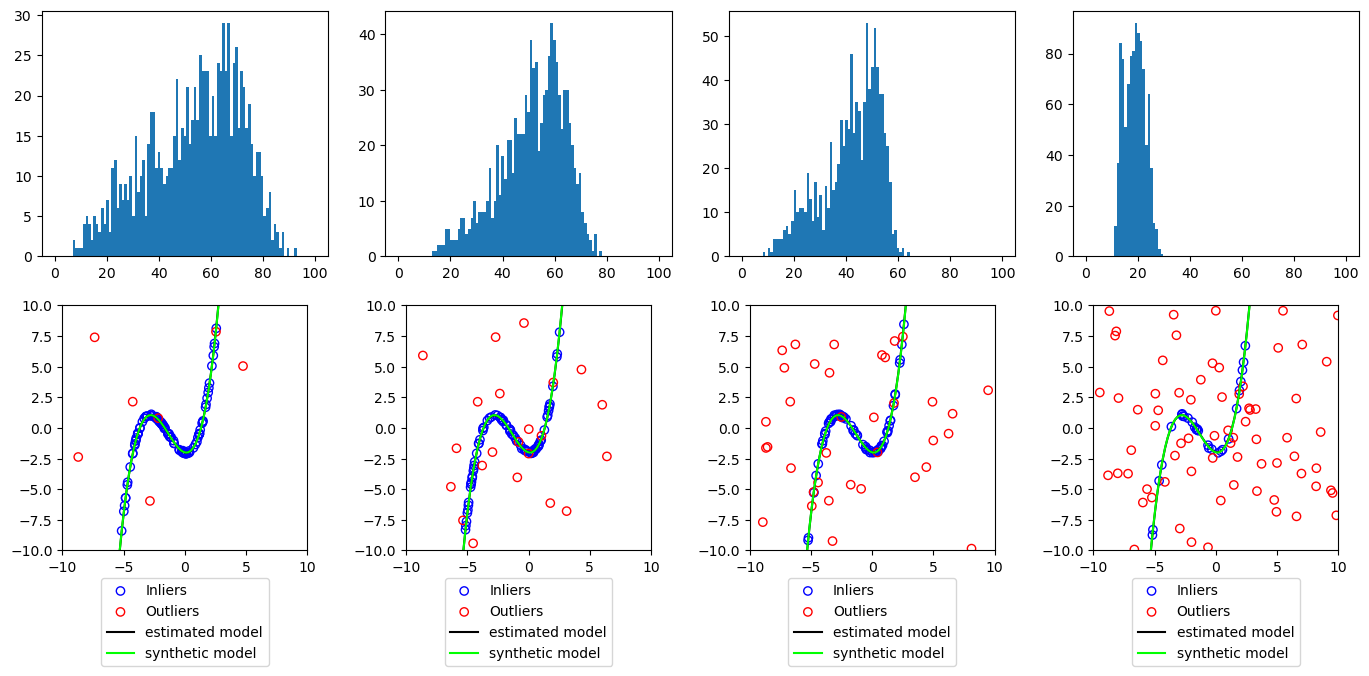

In [9]:
# Running RANSAC and populating historgrams
# It may take some time to run, you can adjust N_RUNS to help with debugging
N_RUNS = 1000
OUTLIER_RATIOS = [0.05, 0.2, 0.3, 0.7]

def plot_ransac_results(synth_poly: Polynomial):
    fig, axes = plt.subplots(2, len(OUTLIER_RATIOS), figsize=(17, 7))

    for r, (ax_hist, ax_vis) in zip(OUTLIER_RATIOS, zip(*axes)):
        inlier_histogram = np.zeros(N_RUNS)

        ransac_inliers = None
        ransac_outliers = None
        model = None

        # TODO : Fill `inlier_histogram` array and assign `ransac_inliers`,
        #        `ransac_outliers`, `model`
        # START
        sample_size = synth_poly.degree + 1
        p = 0.99
        inliers, outliers = synth_poly.generate_points(r)
        points = np.concatenate((inliers, outliers), axis=0)
        n_ransac_it = get_ransac_iterations(r, sample_size, p)

        for it in range(N_RUNS):
            inliers_it, outliers_it, model_it = run_ransac(points, n_ransac_it, sample_size)
            n_inliers = inliers_it.shape[0]
            inlier_histogram[it] = n_inliers
            if np.max(inlier_histogram) <= n_inliers:
                ransac_inliers, ransac_outliers, model = inliers_it, outliers_it, model_it

        # END

        ax_hist.hist(inlier_histogram, range=(0, N), bins=N+1)

        plot_models(ax_vis, ransac_inliers, ransac_outliers, synth_poly, model)

    plt.show()
    plt.close(fig)


plot_ransac_results(poly_a)

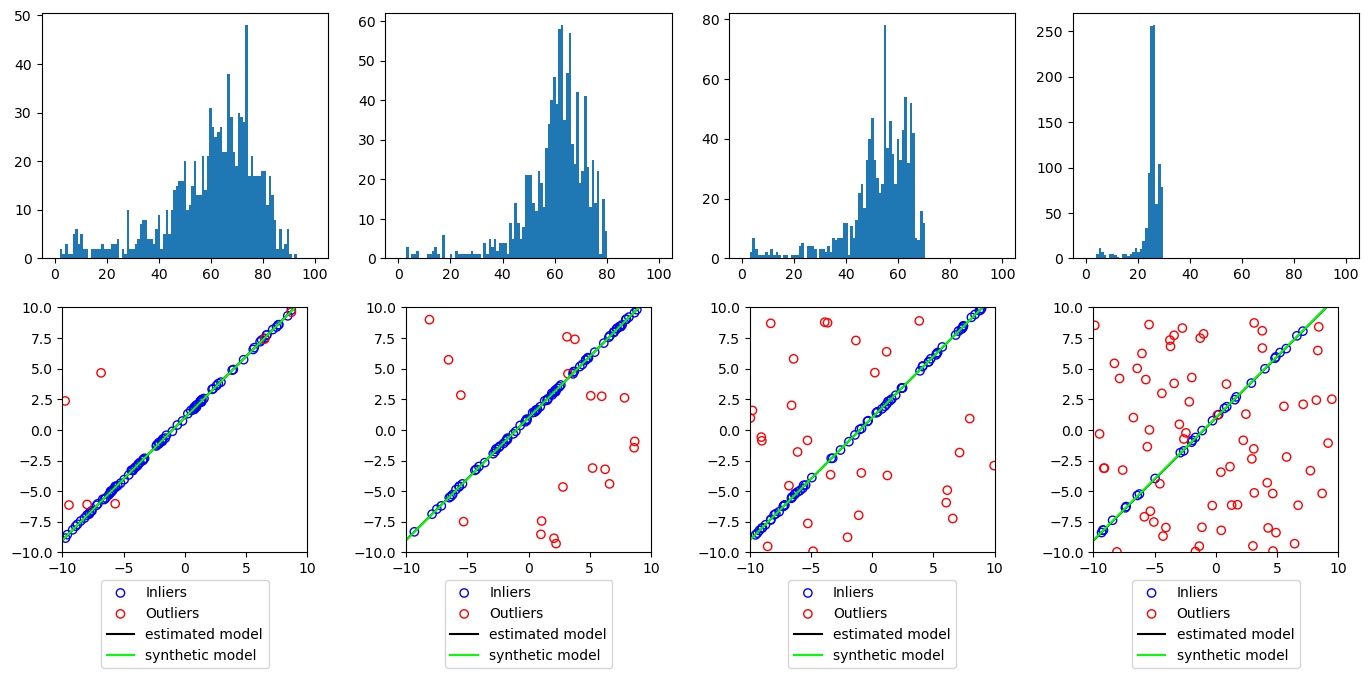

In [10]:
poly_b = Polynomial(np.array([1, 1]))
plot_ransac_results(poly_b)

### 1.3. Exhaustive search

In [11]:
def exhaustive_search(points: np.ndarray, sample_size) -> Tuple[np.ndarray, np.ndarray, Polynomial]:
    """
    points - Nx2 array with the data points
    sample_size - number of samples required to fit the model

    Returns - tuple of inliers and outliers, each defined as Nx2 arrays of the
              respective points, and the best model
    """

    n_points = points.shape[0]

    inliers = points[:0]
    outliers = points
    model = None

    # TODO : Implement exhaustive search by trying all the combinations of minimal data points
    # START
    samples = itertools.combinations(range(n_points), sample_size)
    for sample_id in samples:
      poly_test = Polynomial.fit(points[sample_id, :])
      inlier_mask = poly_test.is_inlier(points)
      if np.sum(inlier_mask) > inliers.shape[0]:
          inliers = points[inlier_mask]
          outliers = points[inlier_mask == False]
          model = poly_test

    # END

    return inliers, outliers, model

Real inliers: 24
RANSAC inliers: 9
Exhaustive search inliers: 24


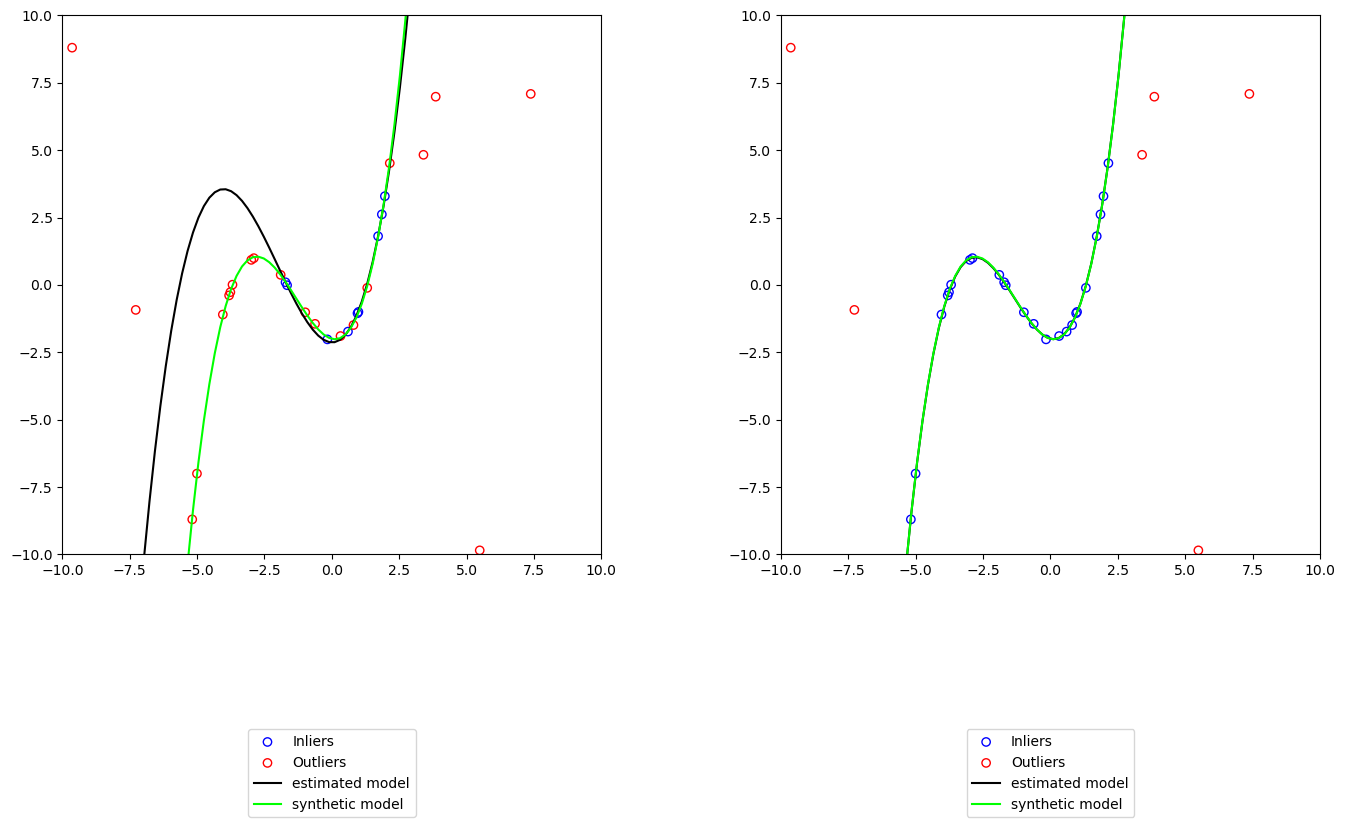

In [12]:
# Running exhaustive search. No need to edit this. Running on a reduced set of points
inliers, outliers = poly_a.generate_points(0.2, 30)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_a.degree + 1
n_iter = get_ransac_iterations(0.2, sample_size, 0.99)
ransac_inliers, ransac_outliers, ransac_model = run_ransac(points, n_iter, sample_size)

exhaustive_inliers, exhaustive_outliers, exhaustive_model = exhaustive_search(points, sample_size)

print(f"Real inliers: {len(inliers)}")
print(f"RANSAC inliers: {len(ransac_inliers)}")
print(f"Exhaustive search inliers: {len(exhaustive_inliers)}")

fig, axes = plt.subplots(1, 2, figsize=(17, 7))

plot_models(axes[0], ransac_inliers, ransac_outliers, poly_a, ransac_model)
plot_models(axes[1], exhaustive_inliers, exhaustive_outliers, poly_a, exhaustive_model)

plt.show()
plt.close(fig)

### Questions and Discussion

<b style="color:red"> Question 1.1: </b> How many combinations (exhaustive search) exist for $N=100$ points?

Let's denote s to be the minimum sample size, then the number of combinations in exhaustive search is
$=\frac{100!}{s!*(100-s)!}$

For polynomial of third degree this will be equal to
$=\frac{100*99*98*97}{4*3*2}=3921225$

<b style="color:red"> Question 1.2: </b> What about the number of RANSAC iterations with $r=5\%$, $20\%$, $30\%$ and $70\%$?

The general formula is $N=\frac{log(1-p)}{log(1-(1-r)^s)}$

Let's again assume that we work with third degree polynomial, so $s=4$ and $p=0.99$. Then:


*   $5\%: N=\frac{log(0.01)}{log(1-(0.95)^4)}=\frac{log(0.01)}{log(1-0.81450625)} = 2.73347005483$, which will be rounded up to $3$
*   $20\%: N=\frac{log(0.01)}{log(1-(0.8)^4)}=\frac{log(0.01)}{log(1-0.4096)} = 8.73920948888; Result = 9$

*   $30\%: N=\frac{log(0.01)}{log(1-(0.7)^4)}=\frac{log(0.01)}{log(1-0.2401)} = 16.7723948836; Result = 17$
*   $70\%: N=\frac{log(0.01)}{log(1-(0.3)^4)}=\frac{log(0.01)}{log(1-0.0081)} = 566.233822897; Result = 567$


<b style="color:red"> Question 1.3: </b> What about when $N=100,000$ points?

The number of RANSAC iterations will not change as it does not depend on number of points, only on the desired success probability, outliers ratio and minimum sample size.
On the contrary the number of combinations for exhaustive search will explode to $=\frac{100000*99999*99998*99997}{4*3*2}$

<b style="color:red"> Question 1.4: </b> Does exhaustive search on all the combinations of data points guarantee the optimal solution (in terms of number of inliers)? Why?

No, it does not, because the exhaustive search still constrained by fitting to the noisy datapoints exactly, so the resulting polynomial may not be identical to the optimal solution, which will lead to less inliers.

<b style="color:red"> Question 1.5: </b> Does RANSAC always find close to the optimal number of inliers? Why? If not, would increasing the number of RANSAC iterations always improve that?

No, RANSAC can in some cases perform poorly if we were unlucky enough. For example if while sampling in all iterations the algorithm selected either some outliners or chose points that do not accurately describe the model due to the presence of noise or collinearity among points.
Increasing the number of iterations will not always improve this issue, as it still does not garantee the selection of the appropriate points, it will only increase the probability of such event.

<b style="color:red"> Question 1.6: </b> Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.

RANSAC and exhaustive search represent the common tradeoff in computer science between speed and precision. Even though exhaustive search guarantees the best possible solution for this fitting approach by exploring all combinations of data points, it quickly becomes impractical as the number of points increases.

In contrast, RANSAC's execution time is independent of the number of data points, making it suitable for large datasets. Although RANSAC may occasionally perform poorly by finding only a few inliers and the execution time of this algorithm grows with increased "success rate" and number of outliers, RANSAC generally provides a good balance between speed and precision for practical cases.

Overall, while exhaustive search ensures the best possible solution, RANSAC provides a practical compromise between speed and precision, making it preferable for most real-world scenarios, especially when dealing with large datasets.

<b style="color:red"> Question 1.7: </b> One of the challenges in using RANSAC for fitting polynomials is choosing appropriate values for the number of iterations and the inlier threshold. How would you go about selecting these values, and what factors should you consider when making this choice? Describe any tradeoffs that may exist between these two parameters, and provide an example scenario where a higher number of iterations or a higher inlier threshold might be preferable.

The true inlier threshold is directly influenced by the noise level in the data. A higher threshold allows more data points to be considered inliers, potentially leading to faster execution of RANSAC but with a higher risk of including outliers in the fitted model.

On contrary, a smaller threshold reduces the inliers ratio, requiring more iterations for RANSAC to achieve the desired "success rate". This increase in computational time may result in a more accurate fitted function if the noise level is low. At the same time, choosing a threshold significantly smaller than the noise level can also lead to RANSAC fitting an incorrect function to the data. Overall, I would say, it's always best to determine the approximate noise level of the data before selecting the inlier threshold.

Another aspect to consider is how many outliers are present in the data. If the outlier ratio is small then RANSAC is more likely will successfully run even with bigger inliers threshold than in the true data. While big outliers presence will require smaller threshold and bigger number of iterations to receive the most accurate results.

## Part 2: IRLS and norms for line fitting

In [13]:
poly_b = Polynomial(np.array([1, 1]))

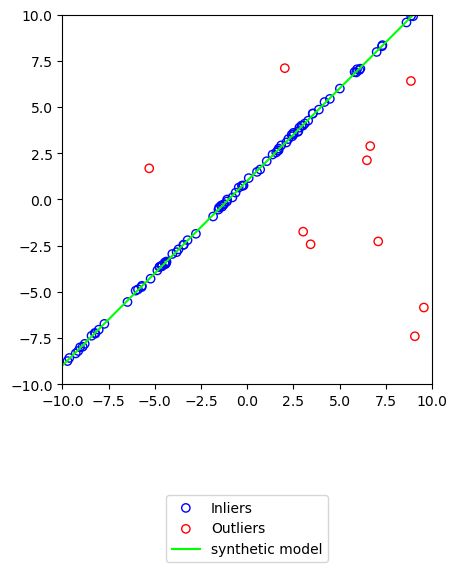

In [14]:
# Plotting the generated line that will be used for model fitting, no need to change this code
inliers, outliers = poly_b.generate_points(0.1)
points = np.concatenate((inliers, outliers), 0)

fig, ax = plt.subplots()
plot_models(ax, inliers, outliers, poly_b)
plt.show()
plt.close(fig)

In [15]:
## Implement different line fitting algorithms

def fit_line_irls_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points

    Returns - fitted Line
    """

    line = np.array([0, 0.5])

    # TODO : Implement line fitting with L-1 norm by using IRLS
    # START

    eps = 1e-8
    x, y = points[:,0], points[:,1]
    X = np.concatenate((np.ones((points.shape[0], 1)), x.reshape(-1,1)), 1)
    w = 1. / np.clip(np.abs(y - X @ line), eps, None)
    while True:
        W = np.diag(w)
        line = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y
        w_next = 1. / np.clip(np.abs(y - X @ line), eps, None)
        if np.linalg.norm(w - w_next) / np.linalg.norm(w) < eps:
            break
        w = w_next

    # END

    return Polynomial(line)


def fit_line_lp_l1(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points

    Returns - fitted Line
    """
    line = np.array([0, 0.5])

    # TODO : Implement line fitting with L-1 norm by using linear programming
    # START

    x, y = points[:,0], points[:,1]
    X = np.concatenate((np.ones((points.shape[0], 1)), x.reshape(-1,1)), 1)
    n = len(x)

    # first 2 reserve for parameters, other for constraints
    c = np.concatenate((np.zeros(2), np.ones(n)))
    # for > and < constraints
    A_eq = np.zeros((2*n, n+2))
    b_eq = np.zeros(2*n)

    A_eq[:n, 0:2] = X
    A_eq[:n, 2:] = -np.eye(n)
    A_eq[n:, 0:2] = -X
    A_eq[n:, 2:] = -np.eye(n)
    b_eq[:n] = y
    b_eq[n:] = -y

    res = linprog(c, A_eq, b_eq, bounds=[None, None])
    line = res.x[:2]

    # END

    return Polynomial(line)


def fit_line_lp_l_inf(points: np.ndarray) -> Polynomial:
    """
    points - Nx2 array with the data points

    Returns - fitted Line
    """
    line = np.array([0, 0.5])

    # TODO : Implement line fitting with L-infinity norm by using linear programming
    # START
    x, y = points[:,0], points[:,1]
    X = np.concatenate((np.ones((points.shape[0], 1)), x.reshape(-1,1)), 1)
    n = len(x)

    # first 2 reserve for parameters, other for constraints
    c = np.concatenate((np.zeros(2), np.ones(1)))
    # for > and < constraints
    A_eq = np.zeros((2*n, 3))
    b_eq = np.zeros(2*n)

    A_eq[:n, 0:2] = X
    A_eq[n:, 0:2] = -X
    A_eq[:, 2] = -np.ones(2*n)
    b_eq[:n] = y
    b_eq[n:] = -y

    res = linprog(c, A_eq, b_eq, bounds=[None, None])
    line = res.x[:2]

    # END

    return Polynomial(line)

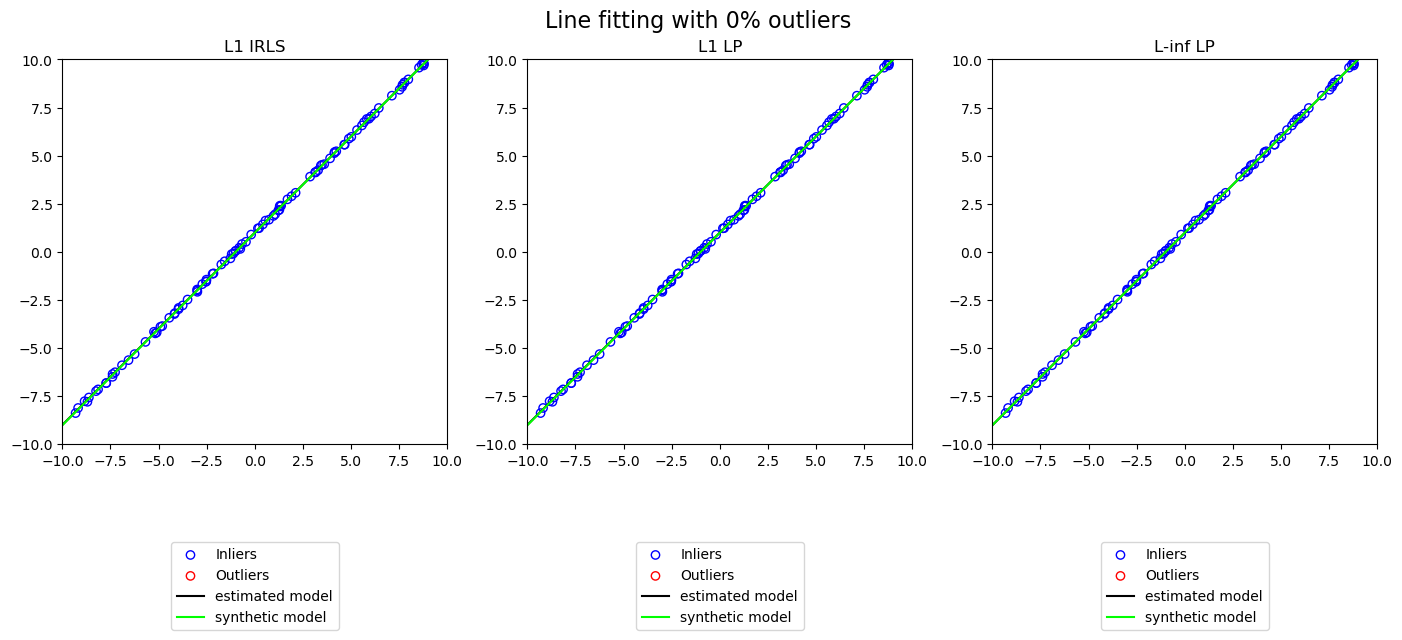

IRLS L1: Polynomial([1.007381252636781, 0.9991978017486094])
LP L1: Polynomial([1.0073812506431876, 0.9991978005221386])
LP L-inf: Polynomial([0.9997333399951734, 1.0001699095242051])


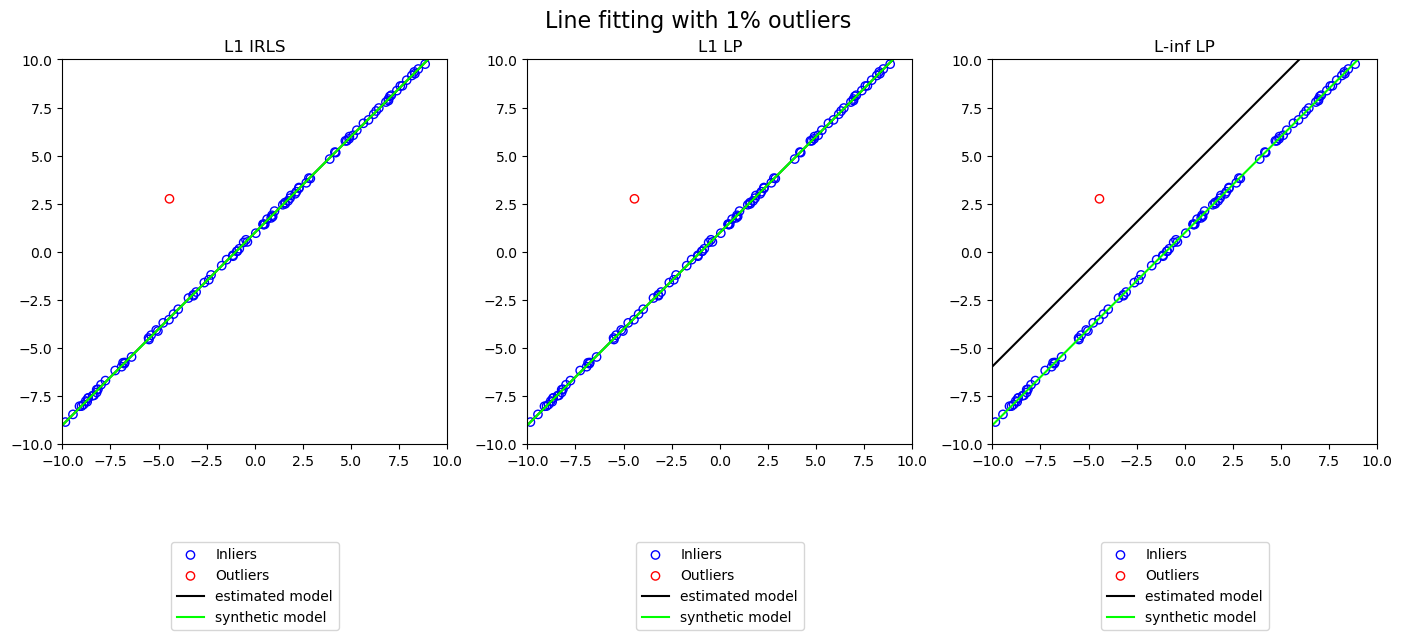

IRLS L1: Polynomial([1.0010318303655534, 0.999688536908764])
LP L1: Polynomial([1.0010318332409924, 0.999688536687704])
LP L-inf: Polynomial([4.051254605386848, 0.999933110875943])


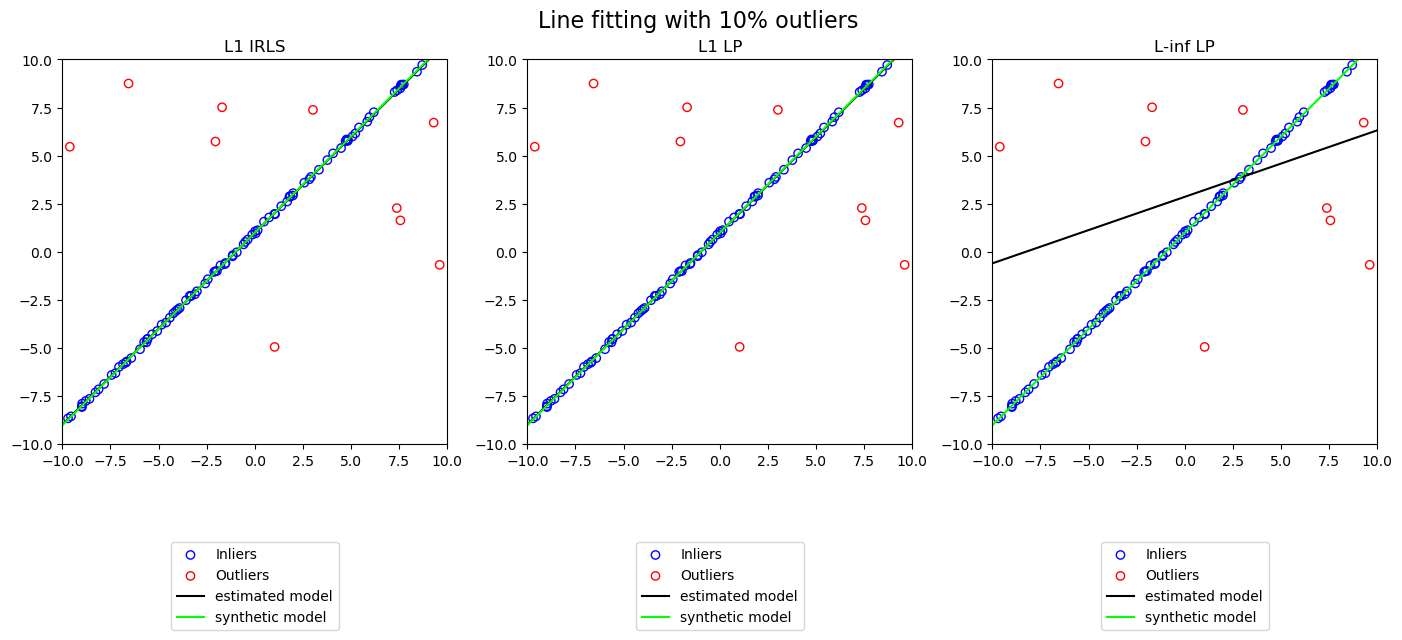

IRLS L1: Polynomial([0.9943188868705013, 0.9963176656270853])
LP L1: Polynomial([0.9943188856310272, 0.9963176642183371])
LP L-inf: Polynomial([2.8638353245674955, 0.34562073763089707])


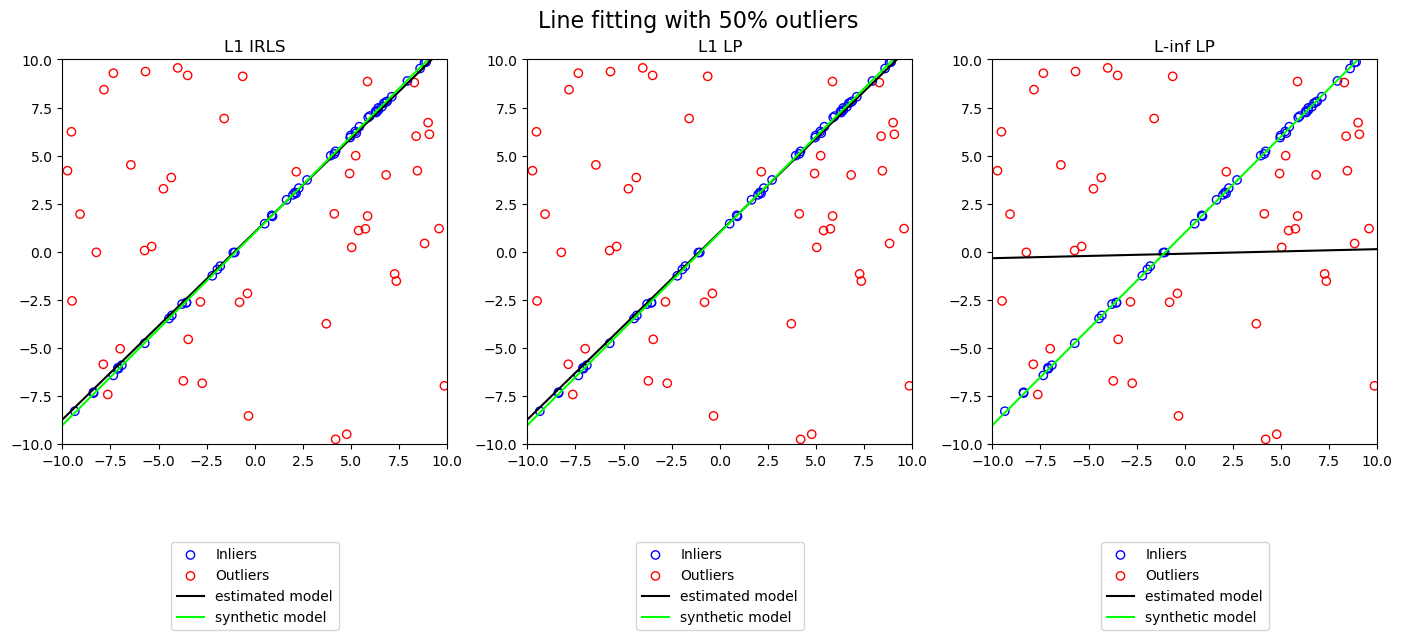

IRLS L1: Polynomial([1.036581343338102, 0.9745145017405927])
LP L1: Polynomial([1.036581344229326, 0.9745145011793737])
LP L-inf: Polynomial([-0.08997784485602267, 0.023490242890828128])


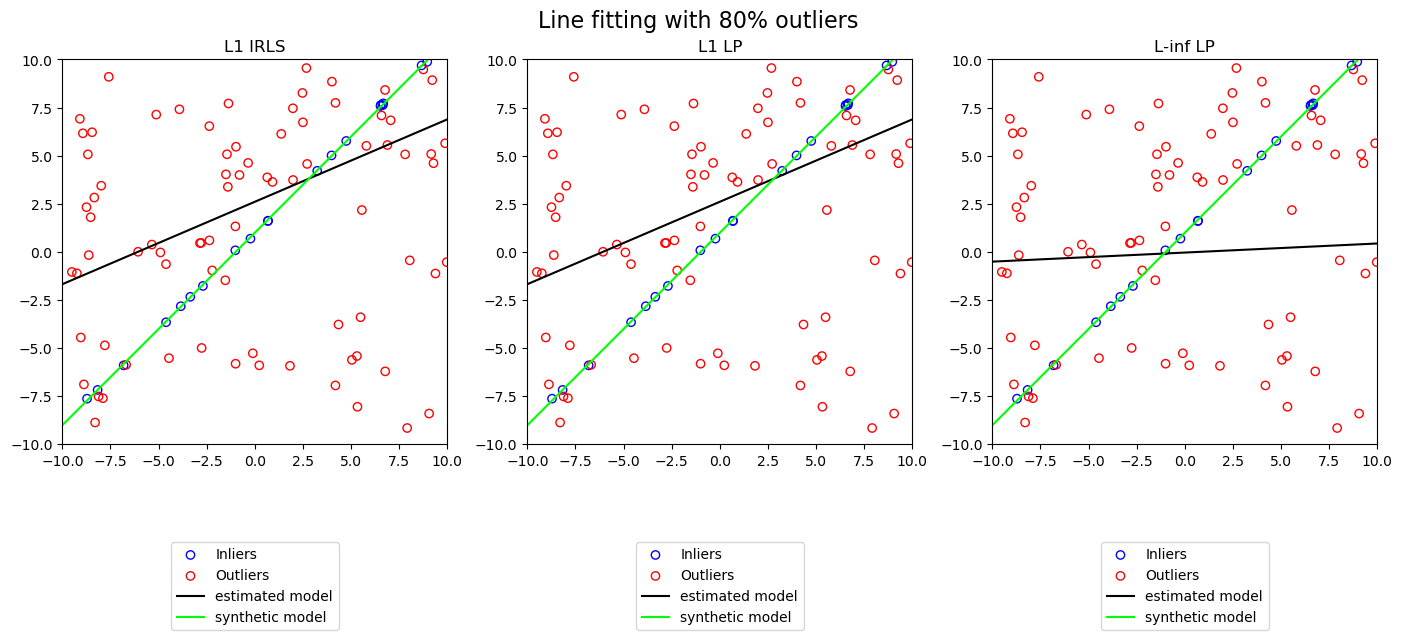

IRLS L1: Polynomial([2.6063078280049345, 0.4281752800565803])
LP L1: Polynomial([2.606307827903115, 0.42817528027992946])
LP L-inf: Polynomial([-0.032180633270550985, 0.0471494341136971])


In [16]:
# Plotting the results. No need to change this code
for r in [0.0, 0.01, 0.1, 0.5, 0.8]:
    inliers, outliers = poly_b.generate_points(r)
    points = np.concatenate((inliers, outliers), 0)

    irls_l1_line = fit_line_irls_l1(points)
    lp_l1_line = fit_line_lp_l1(points)
    lp_l_inf_line = fit_line_lp_l_inf(points)

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)

    plot_models(axes[0], inliers, outliers, poly_b, irls_l1_line, title="L1 IRLS")
    plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1 LP")
    plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf LP")

    plt.show()
    plt.close(fig)

    print(f"IRLS L1: {irls_l1_line}")
    print(f"LP L1: {lp_l1_line}")
    print(f"LP L-inf: {lp_l_inf_line}")


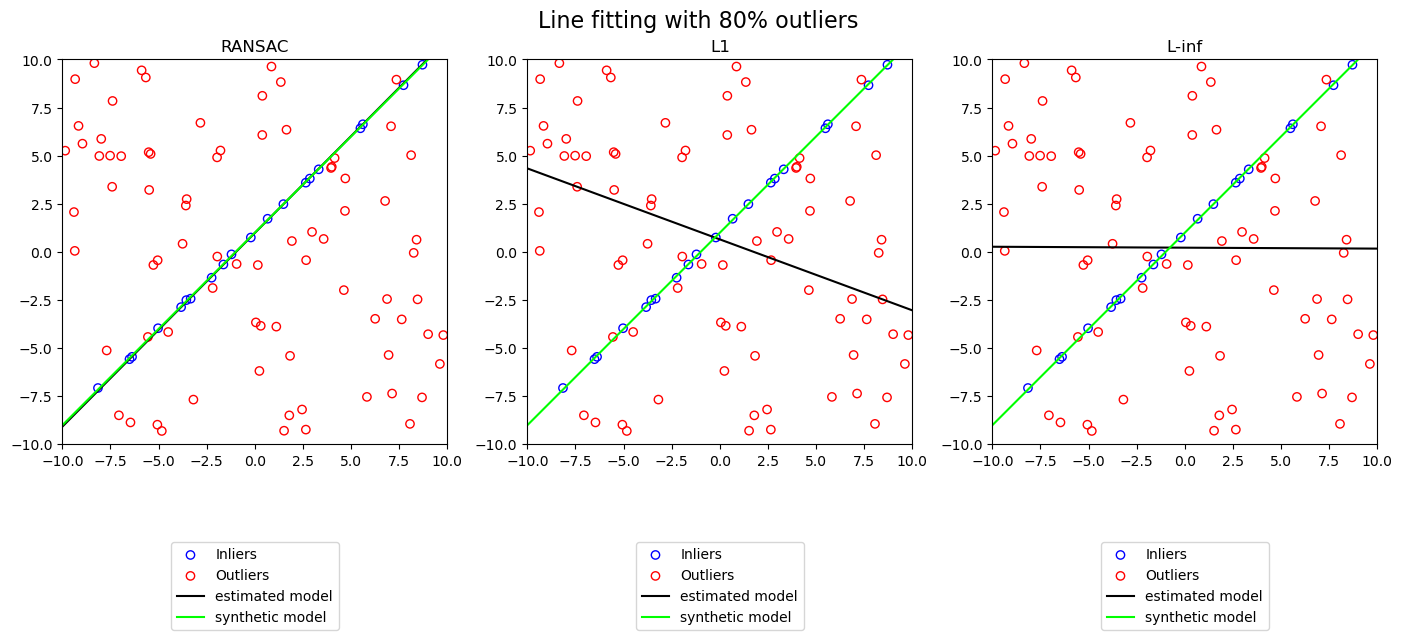

In [17]:
# Comparison with RANSAC
r = 0.8
inliers, outliers = poly_b.generate_points(r)
points = np.concatenate((inliers, outliers), 0)

sample_size = poly_b.degree + 1
n_iter = get_ransac_iterations(r, sample_size, 0.99)
_, _, ransac_line = run_ransac(points, n_iter, sample_size)

lp_l1_line = fit_line_lp_l1(points)
lp_l_inf_line = fit_line_lp_l_inf(points)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

fig.suptitle(f'Line fitting with {r*100:.0f}% outliers', fontsize=16)

plot_models(axes[0], inliers, outliers, poly_b, ransac_line, title="RANSAC")
plot_models(axes[1], inliers, outliers, poly_b, lp_l1_line, title="L1")
plot_models(axes[2], inliers, outliers, poly_b, lp_l_inf_line, title="L-inf")

plt.show()
plt.close(fig)

### Discussion

<b style="color:red"> Question 2.1:</b> Discuss the results obtained by IRLS/LP
solutions.

The results of IRLS with L1 norm converged to the results of LP with L1 norm. This is expected, as both algorithms are based on minimizing L1 norm between the data and the estimated function. It is well-known that L1 norm is quite robust to outliers, even with 50% of outliers we have still received quite good results, the algorithm fails with 80% of outliers though.

In contrast, L-inf norm is highly sensitive to outliers, and as expected fails to recognise the function even in presense of just 1 outlier. The algorithm that uses this norm does not consider the whole data, but only minimizes the maximum error between the function and the furtherst data point.

<b style="color:red"> Question 2.2:</b> Compare and contrast them with RANSAC. What are the key differences between these two approaches? Under what circumstances might one be more suitable than the other?

RANSAC usually produces close-to-true solutions even when up to 80% of the data consists of outliers, as this algorithm has been specifically designed to tackle outliers presence. However, RANSAC is probabilistic, and its results vary across different runs. Additionally, it fits the function precisely to the data points, which may be suboptimal.

Methods based on minimizing norms, such as IRLS and LP, offer high precision and robustness against noise in data. However, they are highly sensitive to outliers, with the exception of the L1-norm, which can handle more outlier dense data, but still not as effectively as RANSAC.

In practice, in my opinion, RANSAC is the best for identifying the outliers in the data before fitting a model, while norm-based methods are preferable when the data contains few or no outliers, and a precise and consistent approximation of the true function is desired.